##### 数据构成
总共 100,000 条评论，其中包括：

- 25,000 条标注的训练集（train/）

- 25,000 条标注的测试集（test/）

- 50,000 条无标注的评论（train/unsup/）

imdb.vocab : 官方给出的词汇表，一行一词，

imdbEr.txt : 保存每个词在IMDb上的期望评分，可以当做一种情感词典，给每句话加一个统计或加权的特征。

##### 标签定义

评分 ≤ 4 的评论标为 负面（neg），评分 ≥ 7 的评论标为 正面（pos）。中性评分（5-6 分）被排除在标注数据之外


Epoch 1 | Train Loss: 0.4366, Acc: 0.8015 | Test Loss:  0.3851, Acc: 0.8364
Epoch 2 | Train Loss: 0.4012, Acc: 0.8277 | Test Loss:  0.3871, Acc: 0.8285
Epoch 3 | Train Loss: 0.3895, Acc: 0.8329 | Test Loss:  0.3869, Acc: 0.8385
Epoch 4 | Train Loss: 0.3757, Acc: 0.8400 | Test Loss:  0.3706, Acc: 0.8442
Epoch 5 | Train Loss: 0.3674, Acc: 0.8435 | Test Loss:  0.3570, Acc: 0.8485
Epoch 6 | Train Loss: 0.3618, Acc: 0.8477 | Test Loss:  0.3721, Acc: 0.8409
Epoch 7 | Train Loss: 0.3589, Acc: 0.8471 | Test Loss:  0.3503, Acc: 0.8534
Epoch 8 | Train Loss: 0.3551, Acc: 0.8497 | Test Loss:  0.3469, Acc: 0.8547
Epoch 9 | Train Loss: 0.3515, Acc: 0.8522 | Test Loss:  0.3464, Acc: 0.8566
Epoch 10 | Train Loss: 0.3497, Acc: 0.8528 | Test Loss:  0.3404, Acc: 0.8546


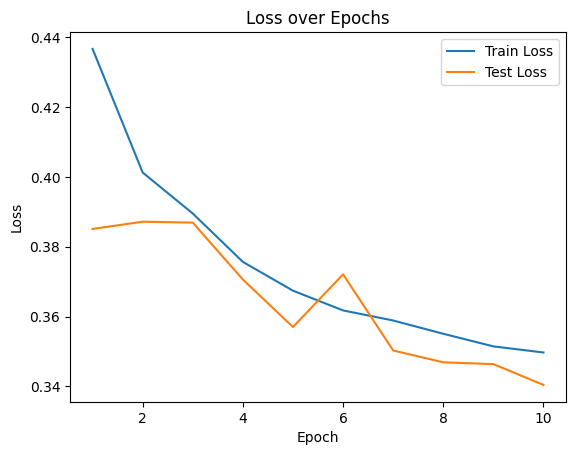

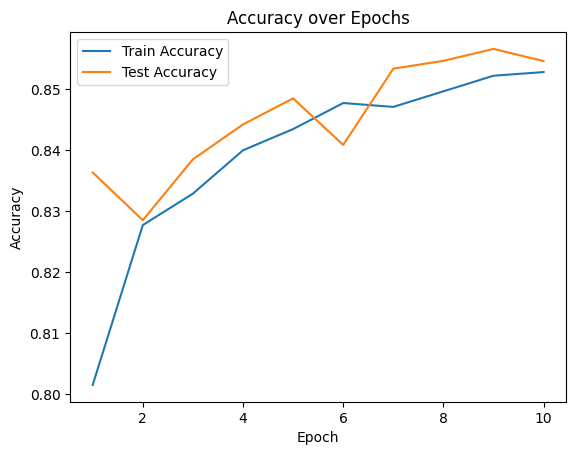

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DATA_DIR   = './data_循环'
TRAIN_DIR  = os.path.join(DATA_DIR, 'train')
TEST_DIR   = os.path.join(DATA_DIR, 'test')
VOCAB_FILE = os.path.join(DATA_DIR, 'imdb.vocab')
ER_FILE    = os.path.join(DATA_DIR, 'imdbEr.txt')

# 词表
vocab_list = []
with open(VOCAB_FILE, 'r', encoding='utf-8') as vf:
    for line in vf:
        tok = line.strip()
        if tok:
            vocab_list.append(tok)

# 词的期望评分
er_values = []
with open(ER_FILE, 'r', encoding='utf-8') as ef:
    for line in ef:
        s = line.strip()
        if s:
            er_values.append(float(s))

er_dict   = dict(zip(vocab_list, er_values)) # 字典 词:评分
vocab_set = set(vocab_list) # 转为集合，后续做快速过滤

# 分词
def tokenizer(text):
    return text.split()

# 排除不在词表的词
def filter_tokens(tokens):
    return [tok for tok in tokens if tok in vocab_set]

class ScoreDataset(Dataset):
    def __init__(self, directory):
        # 读取数据集，samples是[(text, label), ...]的列表
        self.samples = []
        for label in ['pos','neg']:
            path = os.path.join(directory, label)
            for fname in os.listdir(path):
                if not fname.endswith('.txt'):
                    continue
                with open(os.path.join(path, fname), 'r', encoding='utf-8') as f:
                    text = f.read()
                self.samples.append((text, 1 if label=='pos' else 0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, label = self.samples[idx]
        toks = filter_tokens(tokenizer(text))
        # 过滤后没有任何词，防止报错，填一个0分作为默认特征
        if len(toks) == 0: #
            scores = [0.0]
        else:
            # 词到情感值的映射，不在字典的词默认为0.0
            scores = [er_dict.get(tok, 0.0) for tok in toks]
        # 变成 [seq_得分,1]
        seq = torch.tensor(scores, dtype=torch.float32).unsqueeze(-1)
        return seq, torch.tensor(label, dtype=torch.float32)

def collate_batch(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long) # 每条序列的真实长度
    padded = torch.nn.utils.rnn.pad_sequence(
        seqs, batch_first=True, padding_value=0.0
    ) # 把不同长度的句子用0.0在末尾补齐，输出[batch_size, max_len, feature_dim]；
    labels = torch.stack(labels)
    return padded, lengths, labels

class ScoreBiLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes=1):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size, hidden_dim,
            bidirectional=True, batch_first=True
        ) # 双向LSTM
        self.fc = torch.nn.Linear(hidden_dim * 2, num_classes) #双向，所以乘2
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, lengths):
        # x: [batch, seq_len, 1]
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (hidden, _) = self.lstm(packed)
        # hidden: [num_layers*2, batch, hidden_dim]
        h_fwd  = hidden[-2]  # 正向最后一层信息
        h_bwd  = hidden[-1]  # 反向最后一层信息
        h = torch.cat((h_fwd, h_bwd), dim=1)  # [batch, hidden_dim*2]
        return self.sigmoid(self.fc(h)).squeeze() #squeeze()：去掉维度 1，将 [B,1] 变成 [B]，方便后续计算损失和准确率。

BATCH_SIZE = 32
HIDDEN_DIM = 64
EPOCHS     = 10
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds     = ScoreDataset(TRAIN_DIR)
test_ds      = ScoreDataset(TEST_DIR)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_batch)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE,
                          collate_fn=collate_batch)

model     = ScoreBiLSTM(input_size=1, hidden_dim=HIDDEN_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCELoss() # 二元交叉熵损失

def binary_accuracy(preds, y):
    return ((preds >= 0.5).float() == y).float().mean()

train_losses_list, test_losses_list = [], []
train_accs_list, test_accs_list     = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss, total_acc = 0, 0
    # 零梯度->前向->损失和准确率->反向->梯度裁剪->优化器步进
    for x, lengths, y in train_loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x, lengths)
        loss  = criterion(preds, y)
        acc   = binary_accuracy(preds, y)
        loss.backward()
        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        total_acc  += acc.item()
    train_loss = total_loss / len(train_loader)
    train_acc  = total_acc  / len(train_loader)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_acc)
    

    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for x, lengths, y in test_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            preds = model(x, lengths)
            loss  = criterion(preds, y)
            acc   = binary_accuracy(preds, y)
            total_loss += loss.item()
            total_acc  += acc.item()
    test_loss = total_loss / len(test_loader)
    test_acc  = total_acc  / len(test_loader)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_acc)

    print(f"Epoch {epoch} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Test Loss:  {test_loss:.4f}, Acc: {test_acc:.4f}")

plt.figure()
plt.plot(range(1,EPOCHS + 1), train_losses_list, label='Train Loss')
plt.plot(range(1,EPOCHS + 1), test_losses_list, label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1,EPOCHS + 1), train_accs_list, label='Train Accuracy')
plt.plot(range(1,EPOCHS + 1), test_accs_list, label='Test Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()